In [144]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure

In [145]:
class metropolis:
    def __init__(self, N, J=1, B=0):
        self.J = J
        self.N = N
        self.init_random = np.random.random((N, N))
        self.grid_n = np.zeros((N, N))
        self.grid_n[self.init_random >= .75] = 1
        self.grid_n[self.init_random <= .75] = -1
    
    def get_energy(self, grid):
        kernel = generate_binary_structure(2, 1)
        kernel[1][1] = False
        result = - self.J * grid * convolve(grid, kernel, mode='constant', cval=0)
        return result.sum()
    
    def grid(self):
        return self.grid_n
    
    @staticmethod
    @numba.njit("Tuple((f8[:], f8[:], f8[:,:]))(f8[:,:], i8, f8, f8, i8)", nopython=True, nogil=True)
    def algo(arr_spin, times, beta, energy, N):
        arr_spin = arr_spin.copy()
        total_spin = np.zeros(times - 1)
        total_energy = np.zeros(times - 1)
        # x = np.random.randint(0, N, size=(times - 1))
        # y = np.random.randint(0, N, size=(times - 1))
        for t in range(0, times - 1):
            x = np.random.randint(0,N)
            y = np.random.randint(0,N)
            spin_t = arr_spin[x, y]
            spin_prime = -spin_t
            E_t = 0
            E_prime = 0
            if x>0:
                E_t += - spin_t * arr_spin[x-1,y]
                E_prime += - spin_prime * arr_spin[x-1,y]
            if x<N-1:
                E_t += - spin_t * arr_spin[x+1,y]
                E_prime += - spin_prime * arr_spin[x+1,y]
            if y>0:
                E_t += - spin_t * arr_spin[x,y-1]
                E_prime += - spin_prime * arr_spin[x,y-1]
            if y<N-1:
                E_t += - spin_t * arr_spin[x,y+1]
                E_prime += - spin_prime * arr_spin[x,y+1]
            # neighbours = [(x - 1) % N, (x + 1) % N, (y - 1) % N, (y + 1) % N]
            # for nx in [neighbours[0], neighbours[1]]:
            #     E_t += - spin_t * arr_spin[nx, y]
            #     E_prime += - spin_prime * arr_spin[nx, y]
            # for ny in [neighbours[2], neighbours[3]]:
            #     E_t += - spin_t * arr_spin[x, ny]
            #     E_prime += - spin_prime * arr_spin[x, ny]
            dE = E_prime - E_t
            if (dE > 0) & (np.random.random() < np.exp(beta * dE)):
                arr_spin[x, y] = spin_prime
                energy += dE
            elif dE <= 0:
                arr_spin[x, y] = spin_prime
                energy += dE
            total_spin[t] = arr_spin.sum()
            total_energy[t] = energy
            
        return total_spin, total_energy, arr_spin
        
        
    def print_energy(self):
        print(self.get_energy(self.grid_n))
    
    def plot(self):
        plt.imshow(self.grid_n, cmap='binary')

/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [146]:
test = metropolis(N=50)

In [147]:
#test.plot()
test.print_energy()

-2624.0


In [148]:
spins = test.grid()
energy = test.get_energy(spins)

In [149]:
spins, energies, equilibrium = test.algo(spins, 1000000, 0.7, energy, 50)

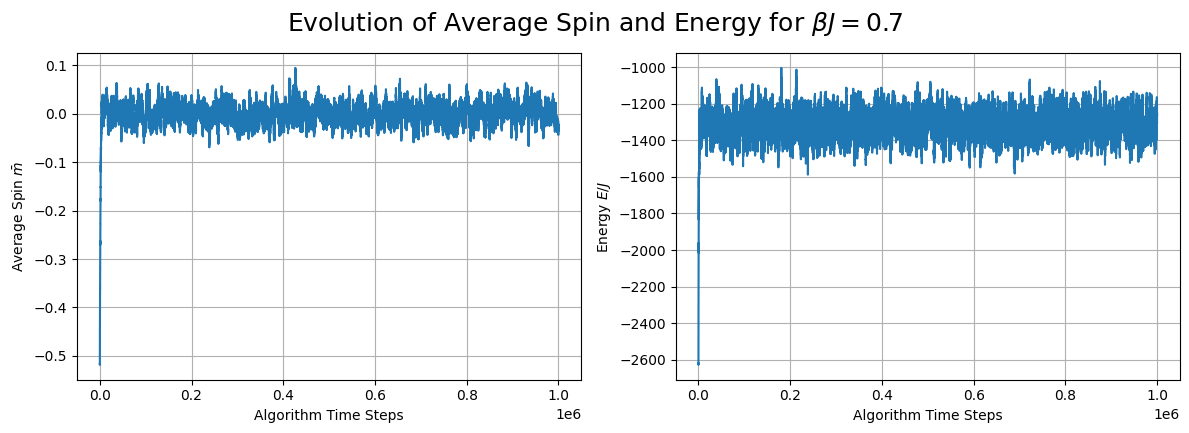

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/50**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

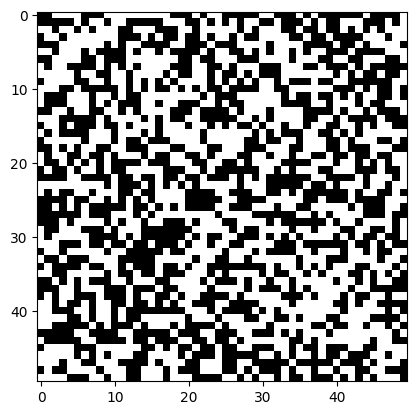

In [151]:
plt.imshow(equilibrium, cmap='binary')

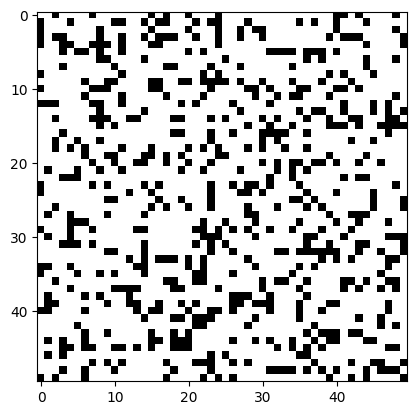

In [152]:
test.plot()